In [59]:
# import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [60]:
# fix random seed
seed = 42
def set_seed(seed=42):
    import random
    # python random
    random.seed(seed)
    # numpy
    np.random.seed(seed)
    # pytorch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
set_seed()

In [61]:
# Params
column_names = (
    ["time", "collision_index"]
    + [f"p{i+1}" for i in range(6)]            # p(t): generalized momentum
    + [f"beta{i+1}" for i in range(6)]         # β(t): from robot dynamics
    + [f"tau_m{i+1}" for i in range(6)]        # τm(t): active motor torques
)

n_joints = 6
test_files_num = 94 # number of collision data for test
train_files_num = 135 # number of collision data for training
R_balanced_ratio = 2.0

# preprocessing

In [62]:
# function

## momentum observer
def mob(df, K0=150.0, n_joints=6, dt=0.01, remove_200ms=True):
    n_shape = df.shape[0]
    for col_num in range(1, n_joints + 1):
        df[f'p_hat_pred{col_num}'] = 0
        df[f'rm_pred{col_num}'] = 0

    for col_num in range(1, n_joints + 1):
        p = df[f'p{col_num}'].values
        tau_m = df[f'tau_m{col_num}'].values
        beta = df[f'beta{col_num}'].values
        p0 = 0.0

        p_hat_pred = np.zeros(n_shape)
        rm_pred = np.zeros(n_shape)
        p_hat_dot_pred = np.zeros(n_shape)

        # initialization
        p_hat_pred[0] = p[0]
        rm_pred[0] = 0.0
        p_hat_dot_pred[0] = tau_m[0] - beta[0] + rm_pred[0]

        for t in range(1, n_shape):
            p_hat_dot_pred[t] = tau_m[t] - beta[t] + rm_pred[t-1]
            p_hat_pred[t] = p_hat_pred[t-1] + p_hat_dot_pred[t] * dt
            rm_pred[t] = K0 * (p[t] - p_hat_pred[t] - p0)

        df[f'p_hat_pred{col_num}'] = p_hat_pred
        df[f'rm_pred{col_num}'] = rm_pred
        df[f'r{col_num}'] = np.abs(rm_pred)
        df[f'p_hat_dot_pred{col_num}'] = p_hat_dot_pred

    if remove_200ms:
        # remove first 200ms
        df.drop(df.index[:20], inplace=True)
    return df

# epsilon threashold 
def calculate_epsilon(df, m=1.1, n_joints=6):
    return np.array(df[[f'rm_pred{i}' for i in range(1, n_joints + 1)]].max().values * m)

# colision detection
def calculate_collision_index(df, e, n_joints=6):
    n_shape = df.shape[0]
    result = np.zeros(n_shape)

    for col_num in range(1, n_joints+1):
        result = np.logical_or(result, np.abs(df[f'rm_pred{col_num}'].values) > e[col_num - 1])
    df['collision_index_pred'] = result.astype('int64')

    return df

# Scaler Calss for normalization
class Normalizer:
    def __init__(self, n_joints=6):
        self.n_joints = n_joints
        self.scaler = []
        self.trigger = True

    def train_scaling(self, df): # for train dataset, to find the min max value of robot free motion dataset
        if self.trigger == False:
            raise Exception('class is already trained')
        else:
            self.trigger = False

        for i in range(1, self.n_joints+1):
            r = df[f'r{i}']
            s = StandardScaler()
            r_normalized = s.fit_transform(r)
            self.scaler.append(s)
            df[f'r_normalized{i}'] = r_normalized
        return df
    
    def test_scaling(self, df): # for test dataset, apply min max value that find in train_scaling
        for i in range(1, self.n_joints+1):
            r = df[f'r{i}'].values
            s = self.scaler[i-1]
            r_normalized = s.transform(r)
            df[f'r_normalized{i}'] = r_normalized
        return df
        

# to scaling from 0 to 1, based in formula in assignment 3
class StandardScaler: 
    def fit_transform(self, data):
        self.min = np.min(data)
        self.max = np.max(data)
        return (data - self.min) / (self.max - self.min)

    def transform(self, data):
        return (data - self.min) / (self.max - self.min)
    
    def extract_minmax(self):
        return self.min, self.max

def extract_data(df):
    r_normalized_col = [f'r_normalized{i}' for i in range(1, n_joints + 1)]
    data = df[r_normalized_col].values
    label = df['collision_index'].values
    return data, label

def feature_extract(data, label, num_window_steps, stride, label_type):
    features = []
    for i in range(0, len(label) - num_window_steps + 1, stride):
        window_data = data[i : i + num_window_steps, :] 
        window_label = label[i : i + num_window_steps]

        if label_type == 'collision':
            if np.all(window_label == 1):
                break
            if np.any(window_label == 1):
                features.append(window_data)
        elif label_type == 'free':
            if np.all(window_label == 0):
                features.append(window_data)
        else:
            features.append(window_data)

    return features

def feature_extract_sin(data, label, num_window_steps=10, stride=1):
    features = []
    featured_label = []
    for i in range(0, len(label) - num_window_steps + 1, stride):
        window_data = data[i : i + num_window_steps, :] 
        window_label = label[i : i + num_window_steps]
        if np.all(window_label == 1):
            break
        elif np.any(window_label == 1):
            features.append(window_data)
            featured_label.append(1)
        elif np.all(window_label == 0):
            features.append(window_data)
            featured_label.append(0)
    return features, featured_label

def make_dataset(df_list, num_window_steps=20, label_type="collision", stride=1):
    features = []
    for df in df_list:
        data, label = extract_data(df)
        feature = feature_extract(data, label, num_window_steps=num_window_steps, stride=stride, label_type=label_type)
        features.extend(feature)
    if label_type == "collision":
        labels = np.ones((len(features),))
    elif label_type == "free":
        labels = np.zeros((len(features),))
    return np.array(features), labels

def make_balanced_dataset(df_coll, df_free, R=50, show=True):
    num_coll = df_coll.shape[0]
    num_free = df_free.shape[0]
    num_free_ideal = num_coll * R
    if show==True: print("number of collision: ", num_coll)
    
    if num_free >= num_free_ideal:

        if show==True: print("(ideal) ratio of coll : free = 1:{:.2f}".format(num_free_ideal / num_coll))
        df_free_ideal = list(df_coll) + list(df_free[0:num_free_ideal,])
    else:
        if show==True: print("(not enough) ratio of coll : free = 1:{:.2f}".format(num_free / num_coll))
        df_free_ideal = list(df_coll) + list(df_free)
        # print("not enough free data")
    return np.array(df_free_ideal)

In [63]:
# process

# file load
df_coll_test = {}
df_coll_train = {}

df_test = pd.read_csv('/Users/iyongbin/Repository/ai_robotics/data/free_test.csv', names=column_names)
df_train1 = pd.read_csv('/Users/iyongbin/Repository/ai_robotics/data/free_train_1.csv', names=column_names)
df_train2 = pd.read_csv('/Users/iyongbin/Repository/ai_robotics/data/free_train_2.csv', names=column_names)

for i in range(1, test_files_num + 1):
    df_coll_test[i - 1] = pd.read_csv(f'/Users/iyongbin/Repository/ai_robotics/data/collisions/coll_test_{i}.csv', names=column_names) 
for i in range(1, train_files_num + 1):
    df_coll_train[i - 1] = pd.read_csv(f'/Users/iyongbin/Repository/ai_robotics/data/collisions/coll_train_{i}.csv', names=column_names)

# ------------------------------------------------------------------------------------------------------------------------------------------------- #

# mob
df_train1 = mob(df_train1)
df_train2 = mob(df_train2)
df_test = mob(df_test)

for i in range(train_files_num):
    df_coll_train[i] = mob(df_coll_train[i])

for i in range(test_files_num):
    df_coll_test[i] = mob(df_coll_test[i])

# ------------------------------------------------------------------------------------------------------------------------------------------------- #

# concat dataset
df_train_list = [df_coll_train[i] for i in range(train_files_num)]
df_train_list.extend([df_train1, df_train2])
df_train = pd.concat(df_train_list, axis=0)

# ------------------------------------------------------------------------------------------------------------------------------------------------- #

# scaling
scale_model = Normalizer()

df_train = scale_model.train_scaling(df_train)

df_train1 = scale_model.test_scaling(df_train1)
df_train2 = scale_model.test_scaling(df_train2)
df_test = scale_model.test_scaling(df_test)

for i in range(test_files_num):
    df_coll_test[i] = scale_model.test_scaling(df_coll_test[i])
for i in range(train_files_num):
    df_coll_train[i] = scale_model.test_scaling(df_coll_train[i])

# ------------------------------------------------------------------------------------------------------------------------------------------------- #

# save data 
x_train_coll, y_train_coll = make_dataset(df_coll_train.values(), label_type="collision")
x_test_coll, y_test_coll = make_dataset(df_coll_test.values(), label_type="collision")

x_train_free, y_train_free = make_dataset([df_train1, df_train2], label_type="free")
x_test_free, y_test_free = make_dataset([df_test], label_type="free")

# ------------------------------------------------------------------------------------------------------------------------------------------------- #


# dataset ratio
x_train = make_balanced_dataset(x_train_coll, x_train_free)
y_train = make_balanced_dataset(y_train_coll, y_train_free, show=False)
x_test = make_balanced_dataset(x_test_coll, x_test_free)
y_test = make_balanced_dataset(y_test_coll, y_test_free, show=False)

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)


number of collision:  2645
(not enough) ratio of coll : free = 1:47.02
number of collision:  1815
(not enough) ratio of coll : free = 1:34.08
x_train shape: (127016, 20, 6)
y_train shape: (127016,)
x_test shape: (63666, 20, 6)
y_test shape: (63666,)


In [64]:
batch_size = 32

# Convert to tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Split training data into train and validation
X_train, X_valid, Y_train, Y_valid = train_test_split(
    x_train, 
    y_train, 
    test_size=0.3,  # 30% for validation
    random_state=seed,
    shuffle=True
)

# Create datasets
Train_dataset = TensorDataset(X_train, Y_train)
Valid_dataset = TensorDataset(X_valid, Y_valid)

train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

# Create data loaders
Train_loader = DataLoader(Train_dataset, batch_size=batch_size, shuffle=True)
Valid_loader = DataLoader(Valid_dataset, batch_size=batch_size, shuffle=False)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_valid)}")
print(f"real Training samples: {len(x_train)}")
print(f"Test samples: {len(x_test)}")

Training samples: 88911
Validation samples: 38105
real Training samples: 127016
Test samples: 63666


- ratio of collision data is 1 : 500 = collision : free
- from 30% of collision starting point, to 30% to ending point
- 

# Model

In [7]:
class CollisionDetector(nn.Module):
    def __init__(self, cnn_out_channels=16, lstm_hidden_size=64, lstm_layers=1):
        super(CollisionDetector, self).__init__()

        # 1D CNN 임베딩
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=6, out_channels=cnn_out_channels, kernel_size=3, padding=1),  # 유지: (B, 16, 20)
            nn.ReLU(),
            nn.Conv1d(in_channels=cnn_out_channels, out_channels=cnn_out_channels, kernel_size=3, padding=1),
            nn.ReLU()
        )

        # LSTM 입력: (seq_len=20, batch, input_size=cnn_out_channels)
        self.lstm = nn.LSTM(input_size=cnn_out_channels,
                            hidden_size=lstm_hidden_size,
                            num_layers=lstm_layers,
                            batch_first=False)

        self.output_layer = nn.Linear(lstm_hidden_size, 1)  # 회귀/분류 목적에 따라 조정

    def forward(self, x):
        x = x.permute(0, 2, 1)
        # x: (batch, channels=6, seq_len=20)
        cnn_out = self.cnn(x)  # shape: (batch, cnn_out_channels, seq_len)
        
        # LSTM 입력 형식으로 reshape
        lstm_in = cnn_out.permute(2, 0, 1)  # (seq_len, batch, input_size)

        lstm_out, _ = self.lstm(lstm_in)  # output: (seq_len, batch, hidden)
        last_hidden = lstm_out[-1]  # 마지막 타임스텝 출력: (batch, hidden)

        output = self.output_layer(last_hidden)  # 최종 출력

        return output

In [8]:
def make_history():
    history = {}
    history['loss'] = []
    history['val_loss'] = []
    history['acc'] = []
    history['val_acc'] = []
    history['cm'] = None
    return history
    
def calculate_metrics(all_labels, all_preds):
    cm = confusion_matrix(all_labels, all_preds)
    tn, fp, fn, tp = cm.ravel()
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    # β=2로 Recall에 더 높은 가중치 부여
    beta = 2
    f_beta = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
    
    return {
        'precision': precision * 100,
        'recall': recall * 100,
        'f1_score': f1_score * 100,
        'f_beta': f_beta * 100,
        'confusion_matrix': cm
    }

def plot_model_result(history):
    plt.figure(figsize=(12, 4))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training Loss', color='blue')
    plt.plot(history['val_loss'], label='Validation Loss', color='red')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(history['acc'], label='Training Accuracy', color='blue')
    plt.plot(history['val_acc'], label='Validation Accuracy', color='red')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_cm(cm):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix (Test Set)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

In [9]:
# in pytorch, model variables are mutable
def train_epoch(model, train_loader, loss_fn, optimizer, threshold=0.5):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    for x, y, in train_loader:
        optimizer.zero_grad()
        y_pred = model(x)
        y = y.float().unsqueeze(1)

        # loss
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # save
        predicted = (y_pred > threshold).float()
        all_preds.extend(predicted.detach().cpu().numpy())
        all_labels.extend(y.detach().cpu().numpy()) # detach -> for not calculate gradiant

    avg_loss = total_loss / len(train_loader)
    cm = confusion_matrix(all_labels, all_preds)
    accuracy = 100 * (cm[0,0] + cm[1,1]) / np.sum(cm)

    return avg_loss, accuracy

def valid_epoch(model, valid_loader, loss_fn, threshold=0.5):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for x, y in valid_loader:
            y_pred = model(x)
            y = y.float().unsqueeze(1)

            # loss
            loss = loss_fn(y_pred, y)
            total_loss += loss.item()

            # save
            predicted = (y_pred > threshold).float()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
            
    avg_loss = total_loss / len(valid_loader)
    cm = confusion_matrix(all_labels, all_preds)
    accuracy = 100 * (cm[0,0] + cm[1,1]) / np.sum(cm)
    return avg_loss, accuracy
    
def evaluate(model, test_loader, loss_fn, threshold=0.5):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0
    
    with torch.no_grad():
        for x, y, in test_loader:
            y_pred = model(x)
            y = y.float().unsqueeze(1)

            # loss
            loss = loss_fn(y_pred, y)
            total_loss += loss.item()

            # save
            predicted = (y_pred > threshold).float()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
            
    avg_loss = total_loss / len(test_loader)
    results = calculate_metrics(all_labels, all_preds)

    return avg_loss, results

In [10]:
epochs=20

In [11]:
# params and model
model = CollisionDetector()
loss_fn = nn.BCEWithLogitsLoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

In [12]:
history = make_history()
for epoch in tqdm(range(epochs)):
    avg_loss, accuracy = train_epoch(model, Train_loader, loss_fn, optim, threshold=0.5)
    val_avg_loss, val_accuracy = valid_epoch(model, Valid_loader, loss_fn, threshold=0.5)
    history['loss'].append(avg_loss)
    history['acc'].append(accuracy)
    history['val_loss'].append(val_avg_loss)
    history['val_acc'].append(val_accuracy)

100%|██████████| 20/20 [1:27:00<00:00, 261.05s/it] 


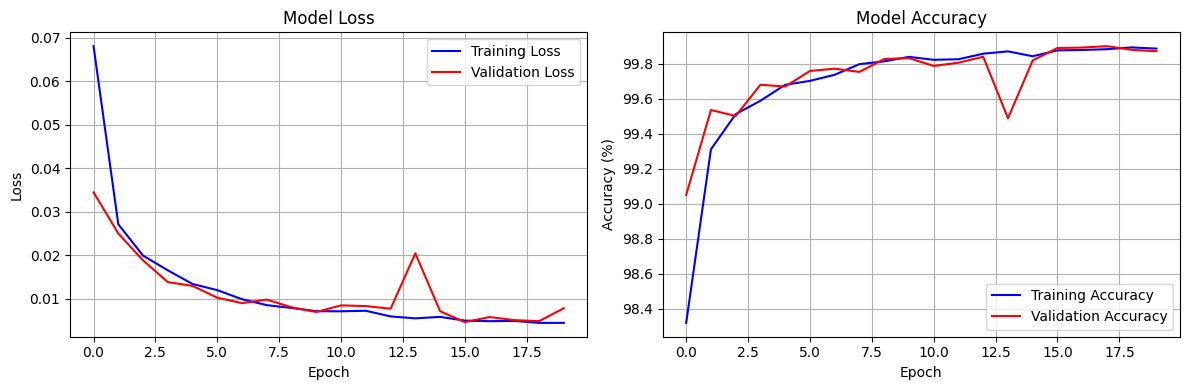

In [20]:
plot_model_result(history)

In [14]:
loss, results = evaluate(model, test_loader, loss_fn)
print("loss: ", loss)
print("f-1 score: ", results['f1_score'])

loss:  0.010412406213057055
f-1 score:  96.69097027481772


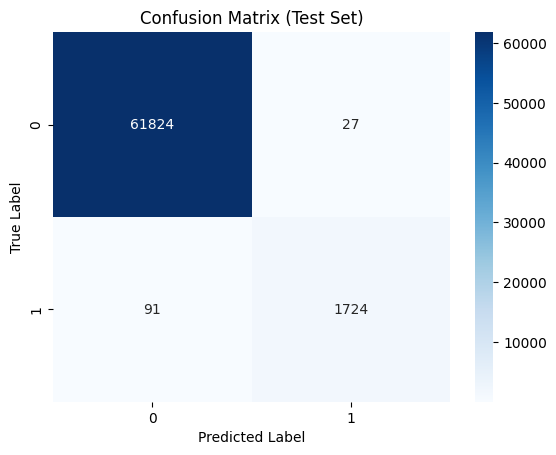

In [25]:
# data ratio max
# threshold = 0.5
plot_cm(results['confusion_matrix'])

In [75]:
best_epochs = 20

# params and model
model = CollisionDetector()
loss_fn = nn.BCEWithLogitsLoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

history = make_history()
for epoch in tqdm(range(best_epochs)):
    avg_loss, accuracy = train_epoch(model, train_loader, loss_fn, optim, threshold=0.5)
    history['loss'].append(avg_loss)
    history['acc'].append(accuracy)

100%|██████████| 20/20 [12:27<00:00, 37.37s/it]


loss:  0.008162451344399592
f-1 score:  95.98853868194843


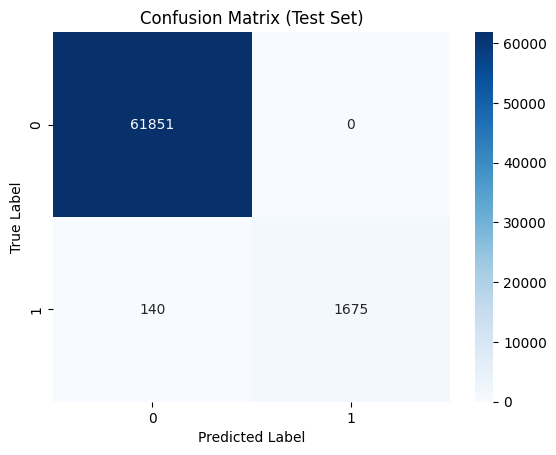

In [76]:
loss, results = evaluate(model, test_loader, loss_fn)
print("loss: ", loss)
print("f-1 score: ", results['f1_score'])
plot_cm(results['confusion_matrix'])

In [77]:
# 전체 모델 저장
model_save_path = '/Users/iyongbin/Repository/ai_robotics/model/'
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optim.state_dict(),
    'scaler_model': scale_model,
    'history': history,
    'epoch': epochs,
}, model_save_path + 'collision_detector.pth')

In [ ]:
# 모델 초기화
model = CollisionDetector()
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

# 체크포인트 불러오기
checkpoint = torch.load(model_save_path + 'collision_detector.pth')

# 모델과 옵티마이저 상태 복원
model.load_state_dict(checkpoint['model_state_dict'])
optim.load_state_dict(checkpoint['optimizer_state_dict'])
scale_model = checkpoint['scaler_model']
history = checkpoint['history']
epochs = checkpoint['epoch']

# 평가 모드로 설정
model.eval()

In [78]:
# for Real time experiment 
class RealTimeCollisionDetector:
    def __init__(self, model, scale_model, e, window_size=20, threshold=0.5):
        # 클래스 초기화시 mob_states 생성
        self.model = model
        self.scale_model = scale_model
        self.mob_states = [{'p_hat': 0.0, 'rm': 0.0} for _ in range(6)]
        self.window_size = window_size
        self.data_buffer = np.array([])
        self.mob_states = [{'p_hat': 0.0, 'rm': 0.0} for _ in range(6)]
        self.threshold = threshold

        self.e = e

    def detect_model(self, r):
        # normalization
        r_normalized = self.scaling_for_line(r)
        # update window
        self.data_buffer = self.window_for_line(self.data_buffer, r_normalized)
        
        # 충돌 예측 (윈도우가 채워진 경우만)
        if len(self.data_buffer) == self.window_size:
            x = torch.tensor(self.data_buffer, dtype=torch.float32).unsqueeze(0)
            with torch.no_grad():
                y_pred = self.model(x)
                is_collision = y_pred > self.threshold
            return int(is_collision)
        return 0

    def detect_baseline(self, r):
        n_joints = 6
        y_pred = 0
        for i in range(n_joints):
            y_pred = np.logical_or(y_pred, r[i] > self.e[i])
        return y_pred
    
    def mob_for_line(self, data, K0=150.0, dt=0.01):
        """한 타임스텝의 momentum observer 계산"""
        n_joints = 6
        r = np.zeros(n_joints)
        
        for i in range(n_joints):
            p = data[f'p{i+1}']
            tau_m = data[f'tau_m{i+1}']
            beta = data[f'beta{i+1}']
            
            # 클래스 변수로 저장된 이전 상태값 사용
            p_hat = self.mob_states[i]['p_hat']
            rm = self.mob_states[i]['rm']
            
            # MOB 계산
            p_hat_dot = tau_m - beta + rm
            p_hat_new = p_hat + p_hat_dot * dt
            rm_new = K0 * (p - p_hat_new)
            
            # 상태 업데이트하여 다음 계산에 사용
            self.mob_states[i]['p_hat'] = p_hat_new
            self.mob_states[i]['rm'] = rm_new
            
            r[i] = np.abs(rm_new)
        return r

    def scaling_for_line(self, r):
        """정규화"""
        r_normalized = np.zeros_like(r)
        for i in range(len(r)):
            scaler = self.scale_model.scaler[i]
            r_normalized[i] = scaler.transform([r[i]])[0]
        return r_normalized

    def window_for_line(self, data_buffer, new_data):
        """슬라이딩 윈도우 업데이트"""
        if len(data_buffer) == 0:
            data_buffer = np.array([new_data])
        else:
            data_buffer = np.vstack([data_buffer, new_data])
        
        # 윈도우 크기(20) 유지
        if len(data_buffer) > self.window_size:
            data_buffer = data_buffer[-self.window_size:]
        
        return data_buffer
    

In [79]:
class aDDCalcualtor:
    def __init__(self, dt=0.01):
        self.pred = []
        self.real = []
        self.timer = None
        self.Delaytime = None
        self.dt = dt
        self._timer_started = False  # 타이머 시작 플래그
        self._timer_stopped = False  # 타이머 정지 플래그
        
    def detect(self, label, label_pred):
        self.real.append(label)
        self.pred.append(label_pred)

        if label == 1 and not self._timer_started:  # 실제 충돌이 발생하고 타이머가 시작되지 않았을 때
            self.timer_start()
        if self.timer is not None and self.Delaytime is None:
            self.counter()
        if label_pred == 1 and self.timer is not None and not self._timer_stopped:  # 충돌이 감지되고 타이머가 정지되지 않았을 때
            self.timer_stop()

    def timer_start(self):
        if not self._timer_started:
            self.timer = 0
            self._timer_started = True
            # print('start_once')

    def timer_stop(self):
        if not self._timer_stopped and self._timer_started:
            self.Delaytime = self.timer
            self._timer_stopped = True
            # print("stop_once")

    def counter(self):
        self.timer += self.dt
    
    def over20(self):
        if self.Delaytime is None:
            self.Delaytime = 20

In [99]:
# baseline

# ------------------------------------------------------------------------------------------------------------------------------------------------- #
# dataset
df_coll_test = {}
df_coll_train = {}

df_test = pd.read_csv('/Users/iyongbin/Repository/ai_robotics/data/free_test.csv', names=column_names)
df_train1 = pd.read_csv('/Users/iyongbin/Repository/ai_robotics/data/free_train_1.csv', names=column_names)
df_train2 = pd.read_csv('/Users/iyongbin/Repository/ai_robotics/data/free_train_2.csv', names=column_names)

for i in range(1, test_files_num + 1):
    df_coll_test[i - 1] = pd.read_csv(f'/Users/iyongbin/Repository/ai_robotics/data/collisions/coll_test_{i}.csv', names=column_names) 
for i in range(1, train_files_num + 1):
    df_coll_train[i - 1] = pd.read_csv(f'/Users/iyongbin/Repository/ai_robotics/data/collisions/coll_train_{i}.csv', names=column_names)

# mob
df_train1 = mob(df_train1)
df_train2 = mob(df_train2)
df_test = mob(df_test)

for i in range(train_files_num):
    df_coll_train[i] = mob(df_coll_train[i])

for i in range(test_files_num):
    df_coll_test[i] = mob(df_coll_test[i])

# make dataset
df_train_list = []
df_train_list.extend([df_train1, df_train2])
df_train = pd.concat([df_train1, df_train2], axis=0)

df_test_list = [df_coll_test[i] for i in range(len(df_coll_test.values()))]
df_test_list.extend([df_test])
df_test_full = pd.concat(df_test_list, axis=0)

# ------------------------------------------------------------------------------------------------------------------------------------------------- #
e = calculate_epsilon(df_train, m=1.1)

In [ ]:
# comparation baseline and data based model
DelayedTimes_model = []
DelayedTimes_baseline = []
DFs_model = 0
DFs_baseline = 0

# Initialize results dictionary to store predictions
results = {}
results['model'] = []  # For model predictions
results['baseline'] = [] # For baseline predictions
results['real'] = []  # For actual labels
results['times'] = []  # For timestamps
results['collision_num'] = []  # To track which collision test case

y_pred_model = []
y_pred_baseline = []
y = []

model.eval()
detector = RealTimeCollisionDetector(model, scale_model, e, threshold=0.5) 

# collision test
for i, df in enumerate(df_coll_test.values()):
    # DFs
    flag_DFs_model = 1
    flag_DFs_baseline = 1

    # aDD
    clock_model = aDDCalcualtor()
    clock_baseline = aDDCalcualtor()

    for j in range(df.shape[0]):
        data = df.iloc[j]
        label = data['collision_index']

        # collision detection
        r = detector.mob_for_line(data)
        label_pred_model = detector.detect_model(r)
        label_pred_baseline = detector.detect_baseline(r)

        y_pred_model.append(label_pred_model)
        y_pred_baseline.append(label_pred_baseline)
        y.append(label)


        # delay time stamp
        clock_model.detect(label, label_pred_model)
        clock_baseline.detect(label, label_pred_baseline)

        if label_pred_model and flag_DFs_model:
            flag_DFs_model = 0
        
        if label_pred_baseline and flag_DFs_baseline:
            flag_DFs_baseline = 0

    clock_model.over20()
    clock_baseline.over20()
    
    DelayedTimes_model.append(clock_model.Delaytime)
    DelayedTimes_baseline.append(clock_baseline.Delaytime)

    if flag_DFs_model:
        DFs_model_ += 1
    if flag_DFs_baseline:
        DFs_baseline += 1

FPs_model = 0
FPs_baseline = 0


# collision free test
for i, data in enumerate(df_test.values):
    data = df_test.iloc[i]
    label = data['collision_index']

    # collision detection
    r = detector.mob_for_line(data)
    label_pred_model = detector.detect_model(r)
    label_pred_baseline = detector.detect_baseline(r)

    if label_pred_model: FPs_model += 1
    if label_pred_baseline: FPs_baseline += 1

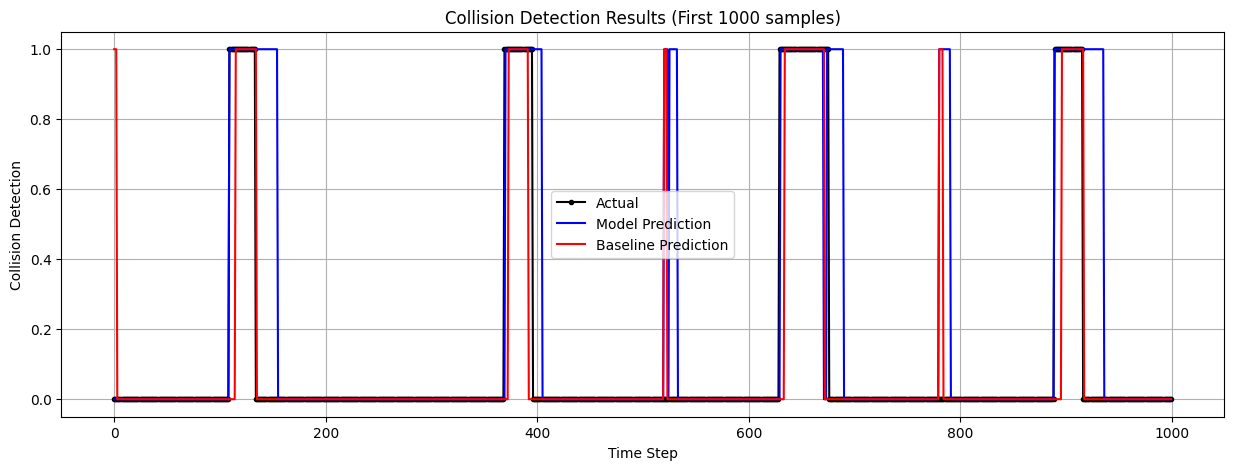

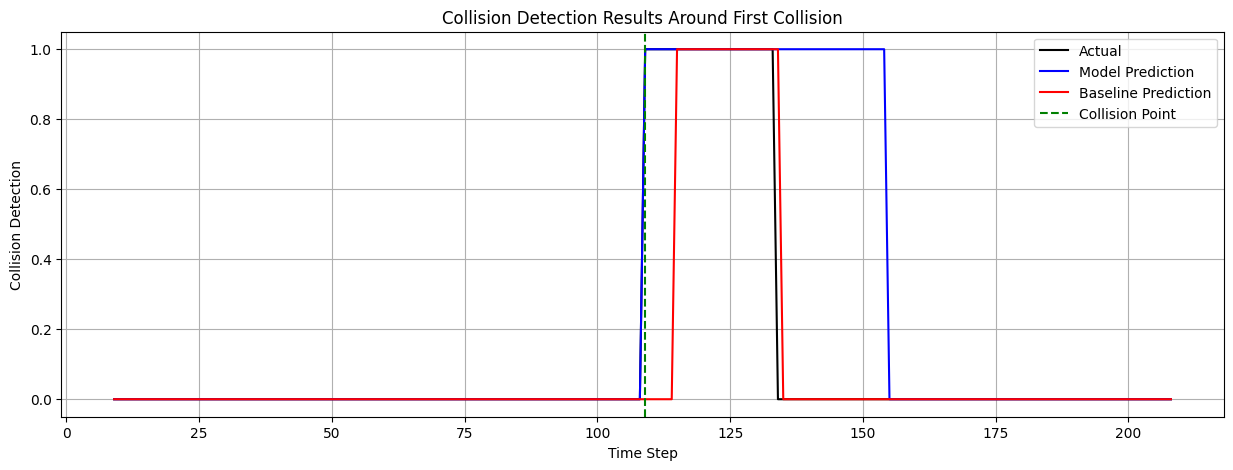

In [114]:
# 결과 저장
results = {
    'model': y_pred_model,
    'baseline': y_pred_baseline,
    'real': y,
    'times': np.arange(len(y))
}

# 결과 시각화 (처음 1000개 데이터포인트만)
plt.figure(figsize=(15, 5))
plt.plot(results['times'][:1000], results['real'][:1000], label='Actual', color='black', marker='.')
plt.plot(results['times'][:1000], results['model'][:1000], label='Model Prediction', color='blue')
plt.plot(results['times'][:1000], results['baseline'][:1000], label='Baseline Prediction', color='red')
plt.xlabel('Time Step')
plt.ylabel('Collision Detection')
plt.title('Collision Detection Results (First 1000 samples)')
plt.legend()
plt.grid(True)
plt.show()

# 첫 번째 충돌 주변 구간 시각화 (충돌 전후 100 타임스텝)
collision_idx = next(i for i, v in enumerate(results['real']) if v == 1)
start_idx = max(0, collision_idx - 100)
end_idx = min(len(results['real']), collision_idx + 100)

plt.figure(figsize=(15, 5))
plt.plot(results['times'][start_idx:end_idx], results['real'][start_idx:end_idx], 
         label='Actual', color='black')
plt.plot(results['times'][start_idx:end_idx], results['model'][start_idx:end_idx], 
         label='Model Prediction', color='blue')
plt.plot(results['times'][start_idx:end_idx], results['baseline'][start_idx:end_idx], 
         label='Baseline Prediction', color='red')
plt.axvline(x=results['times'][collision_idx], color='green', linestyle='--', 
            label='Collision Point')
plt.xlabel('Time Step')
plt.ylabel('Collision Detection')
plt.title('Collision Detection Results Around First Collision')
plt.legend()
plt.grid(True)
plt.show()


In [106]:
# Calculate average detection delay (aDD)
aDD_model = np.mean(DelayedTimes_model)
aDD_baseline = np.mean(DelayedTimes_baseline)

# Print comparison results
print("=== Model Performance Comparison ===")
print(f"Data-based Model:")
print(f"- Average Detection Delay (aDD): {aDD_model:.4f}s")
print(f"- Missed Detections (DFs): {DFs_model}")
print(f"- False Positives (FPs): {FPs_model}")
print("\nBaseline Model:")
print(f"- Average Detection Delay (aDD): {aDD_baseline:.4f}s")
print(f"- Missed Detections (DFs): {DFs_baseline}")
print(f"- False Positives (FPs): {FPs_baseline}")

=== Model Performance Comparison ===
Data-based Model:
- Average Detection Delay (aDD): 0.0216s
- Missed Detections (DFs): 0
- False Positives (FPs): 0

Baseline Model:
- Average Detection Delay (aDD): 1.7764s
- Missed Detections (DFs): 6
- False Positives (FPs): 0


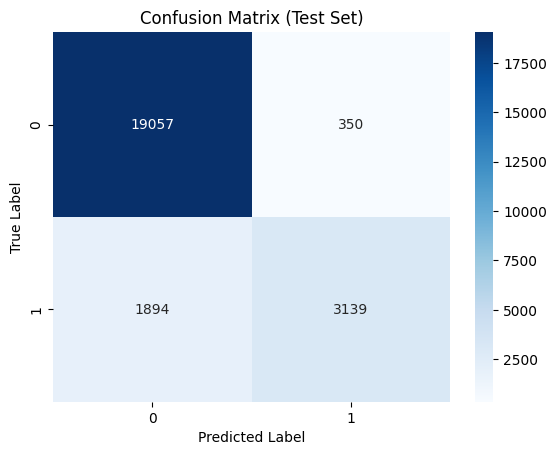

In [108]:
# confusion matrix comparsion

# model
plot_cm(confusion_matrix(y_pred_model, y))




In [110]:
1894 + 350

2244

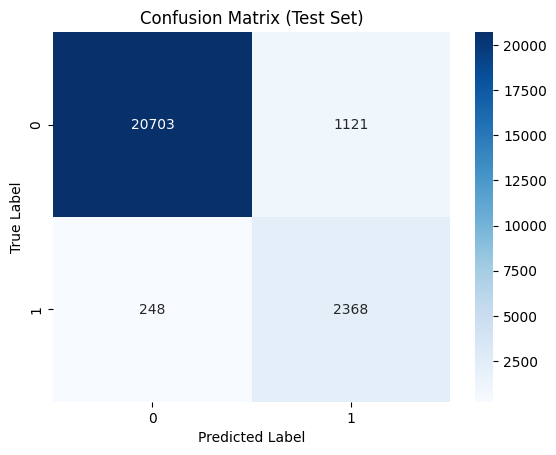

In [109]:
# baseline
plot_cm(confusion_matrix(y_pred_baseline, y))

In [111]:
1121 + 248

1369